# Bayesian Linear Regression of Housing Prices

So this analysis is meant to highlight the benefits of applying a Bayesian methodology to a linear regression, as opposed to the typical "frequentist" approach. 

We are going to use the "Housingprices.csv" file from kaggle (in the repo) which gives a few features from 127 house prices. We will attempt to create a predictive model using a multiple regression based on these catagegorical and continuous variables. 

In [16]:
#The Data set in question takes this form:

#Home	Price	SqFt	Bedrooms	Bathrooms	Offers	Brick	Neighborhood
#1	    114300	1790	2	        2	        2	    No	    1
#2	    114200	2030	4	        2	        3	    No	    1
#3	    114800	1740	3	        2	        1	    No	    1
#4	    94700	1980	3	        2	        3	    No	    1

# Lets import all the packages we require. 
# I found this guide incredibly helpful for installing pymc3 on windows due to its dependencies: https://github.com/pymc-devs/pymc/issues/4937
import theano as tp
import numpy as np
import pandas as pd 
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import arviz as az
import bambi as bi
import xarray as xr
from numpy.random import default_rng
import pymc3 as pm
print(f"Running on PyMC3 v{pm.__version__}")

#Lets also initialize a random seed for reproducibility

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Running on PyMC3 v3.11.2


# First things first....
We need to import the dataset and start doing some exploratory data analysis. While this data set is mostly cleaned now is when we would tidy up any data type discepancies, or any NA values. For example, the "Brick" column is ripe for one-hotting. We can alter this column to be a binary "0" for no, and "1" for yes.

In addition to this the "Neighborhood" column has already been altered to show the compas location numerically:

- 0 = North
- 1 = East, 
- 3 = West. 

South isn't included, but we could make some assumptions the data set is a continuous (ex. 1.5 = South-East) or just leave it discrete integers. Either situation works for the multiple regression, but out data set will be left discrete. 

We can also do some normalization of the continuous value columns in this step if it is required, but it won't really impact our analysis as it stands. 

In [18]:
# Import dataset
df = pd.read_csv('Housingprices.csv')

# Select only categorical variables and one-hot
category_df = df.select_dtypes('object')
# One hot encode the variables
dummy_df = pd.get_dummies(category_df)
# Put the Price back in the dataframe
dummy_df['Price'] = df['Price']

# Find correlations with Price for the one-hot variables to check for linearity
print(f"Categorical Variable Correlation Coefficients: \n {dummy_df.corr()['Price'].sort_values(ascending=False)}\n")
# Find correlations with Price for the continuous variables to check for linearity
print(f"Continuous Variable Correlation Coefficients: \n {df.corr()['Price'].sort_values(ascending=False)}\n")


#Replace "yes/no" with binary for Brick
df['Brick'] = dummy_df['Brick_Yes'].astype('int64')

#Split results into test and train. Based on the correlations lets drop "home" and "offer" as they are only weakly correlated. 
# We could back this decision up by getting an adjusted R^2 score with the features in/out, but lets be lazy...
X_train, X_test, y_train, y_test = train_test_split(df[['SqFt', 'Bedrooms', 'Bathrooms', 'Brick', 'Neighborhood']], df['Price'], test_size = 0.20, random_state=42)
# Going to combine the "label" and "feature" vectors for the upcoming analysis.
X_train_comb = pd.concat([y_train, X_train], axis=1)
X_test_comb = pd.concat([y_test, X_test], axis=1)

#check an Ordinary Least-squares (OLS) regression as the baseline since there seems to be fairly good linear correlation
OLS = LinearRegression().fit(X_train, y_train)
OLS_score = OLS.score(X_train, y_train)
ols_formula = 'Price = %0.2f ' % OLS.intercept_
for i, col in enumerate(X_train.columns):
    ols_formula += '+ %0.2f * %s ' % (OLS.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

print(f'OLS R^2: {OLS_score}\nFormula: {ols_formula}')

Univariate Variable Correlation Coefficients: 
 Price        1.000000
Brick_Yes    0.452817
Brick_No    -0.452817
Name: Price, dtype: float64

Continuous Variable Correlation Coefficients: 
 Price           1.000000
Neighborhood    0.751288
SqFt            0.552982
Bedrooms        0.525926
Bathrooms       0.523258
Home            0.108190
Offers         -0.313636
Name: Price, dtype: float64

OLS R^2: 0.804202691328443
Formula: Price = 14816.94 + 37.06 * SqFt + 2139.08 * Bedrooms + 5987.76 * Bathrooms + 16717.60 * Brick + 12321.41 * Neighborhood 


Okay so far so good. We have shown some features have a decent enough correlation coefficient and scale linearly with price. When we combine them into a multiple regression the coefficient of determination is fairly good, meaning our model fit is explaining a majority of the variance in the data. Typically in this step if we had some suspicions about an appropirate model we could check to see if the residuals of the regression were normally distributed. If they were then thats great, our model is well suited to the data. If not, then we may be interested in another model.

Its also good to step back and see if our model makes sense. The houses appear to have a baseline price of $14816 based on the intercept. We can also see that the addition of each feature increases the overall price. Sounds reasonable in this circumstance.

Next up its always good to plot the various features against each other to see if we can glean any trends. This is very easy with PairGrid from seaborn and is shown below. From this plot we can see a few things:

1. SqFt, Bedrooms, and bathrooms scale with Price unsurprisingly.
2. Brick houses look to have a higher price on average.
3. The west side of town looks to be a bit bougier in terms of price. 
4. More offers look to weakly hurt the house price. 
5. The prices for homes look to be normally distributed, which will influence the priors in our Bayesian approach.

C:\Users\Ralph\anaconda3\envs\pm3env\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


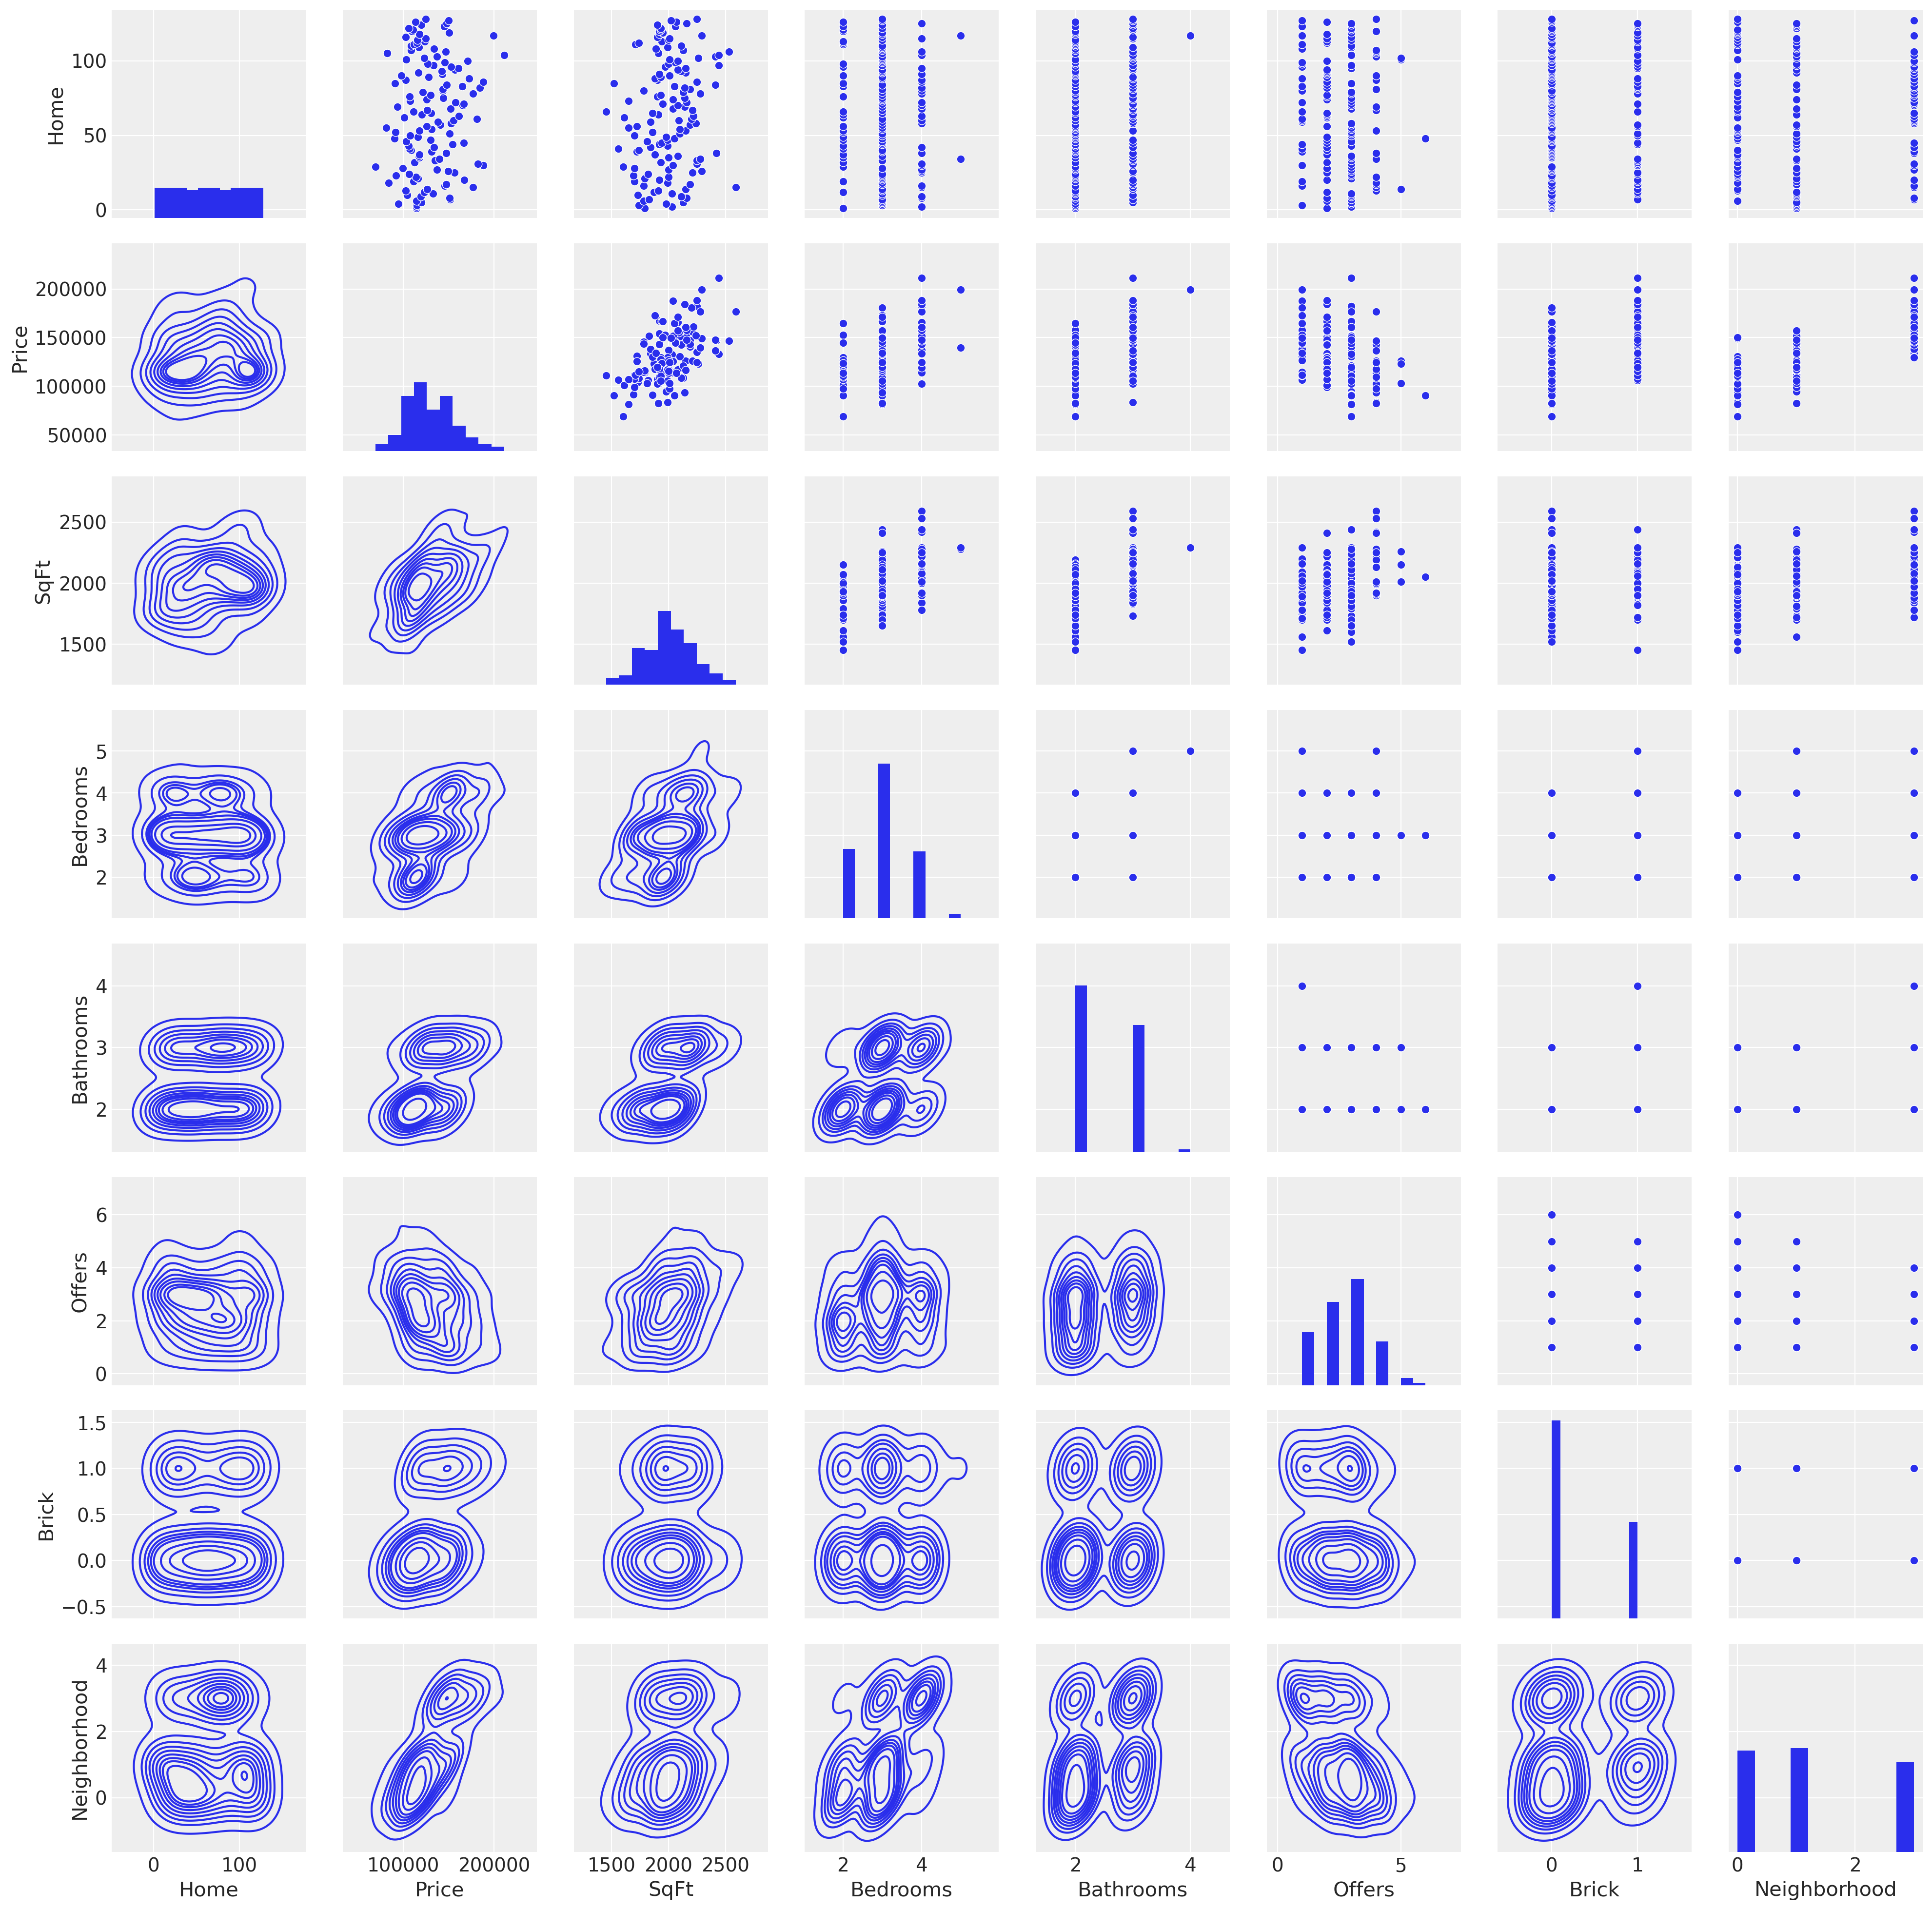

In [6]:
# Paris plot of all features and trends
g = sns.PairGrid(df)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(plt.pyplot.hist)

# Bayesian Regression
Now that we have established our baseline its onto the main event. Its important to note though that in a realistic situation we would want to cross-validate with a bunch of models to see which suits us best, like SVM, gradient boosted, etc. After we picked an appropriate one we could also bootstrap from it, size permitting, to check the spread of model parameters we get. That being said, this is more of a guide to the Bayesian approach for a linear regression. 

I should preface and say there is nothing particularly better about the Bayesian linear regression in this situation. Its simply another tool in the data analysis tool box with strengths in some areas and weaknesses in others. The particularly attractive feature of a Bayesian linear regression is its ability to model uncertaintly. With a frequentist approach like the OLS above we assume there is exactly one "true" set of model parameters. We find estimates of this "true" model based on the sample size, and scale confidence intervals around it accordingly. The larger the sample size, the closer we are to the "true" model. 

In a very brief qualitative summary...

with the Bayesian approach we instead assume that there is uncertainty in the model parameters themselves. We take our prior beliefs of the system, and update them with likelihoods from sampled data. This updated understanding of the system is represented by our "posterior distribution". With this posterior distribution we can outline what our best guess is for an output, given certain inputs, and quantify the uncertainty in our guess with a distribution.

The tricky thing with using the Bayesian approach for continuous variables is that exact solutions involve some wild integrals. Luckily, we have a few tricks up our sleeve in the form of Markov-chain Monte-Carlo (MCMC) methods. Using algorithms like Gibbs and Metropolis-Hastings allows us to sample from our posterior distribution without ever actually solving for it explicitly!

This approach is best implemented in python using Bambi and pymc3:

In [154]:
# Bayesian Linear Regression:

# First we define the formula for the interactions of our features (just the normal linear equation for now). 
# If we wanted to here we could also approch this as a mixed effects model...
# and assume things like bathroom count are more random effects sampled from a population. 
# However, lets keep things simple here. 

# Our forumla will be of the form y = ß^T * X + ε, with ß being a vector of our regression model parameters...
# X being a matrix of our input features, and ε being some random error around the measurement. 
# We will assume the error is normally distributed, so the equation can take the form...
# y ~ N(ß^T * X, σ^2)
formula = 'Price ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns])

# If not specified, Bambi will choose smart distributions to define the priors. 
# This defaults to a normal distribution as we didn't specify any informative priors. As a result our posterior will be forced to be conjugate
# in this case as well.
# Basically in not specifying an informative prior we are letting the sample data heavily influence our posterior.
# If we choose to specify informative priors, our posterior becomes less senstive to the sample data (regularization). 
# To my knowledge this is actually where ridge and lasso regressions come from, the L1 and L2 regularization penalties can be derived from the pull the prior
# has on the posterior distribution, but I digress...
model_1 = bi.Model(formula, X_train_comb)

# Take 4 random walks "chains" through the 2000 posterior samples "draws". The more chains the better for defining the posterior within reason.
fitted = model_1.fit(draws = 2000, chains=4)

# We can use the "predict" method to sample from the posterior and re-create a data set with the model parameters determined. 
# We can use this in a post-predictive check (PPC) to see if our synthetic data is similar to the real data. 
# This is a generally a good sanity check to validate the model is a good fit.
# Run this to do the ppc later on: model_1.predict(fitted, kind="pps", draws=1000)
# Otherwise the line below is for the prediction section.

model_1.predict(fitted, data=X_test_comb, kind="pps", draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Price_sigma, Neighborhood, Brick, Bathrooms, Bedrooms, SqFt, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


C:\Users\Ralph\AppData\Local\Temp\ipykernel_10344\501068743.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.pyplot.tight_layout()


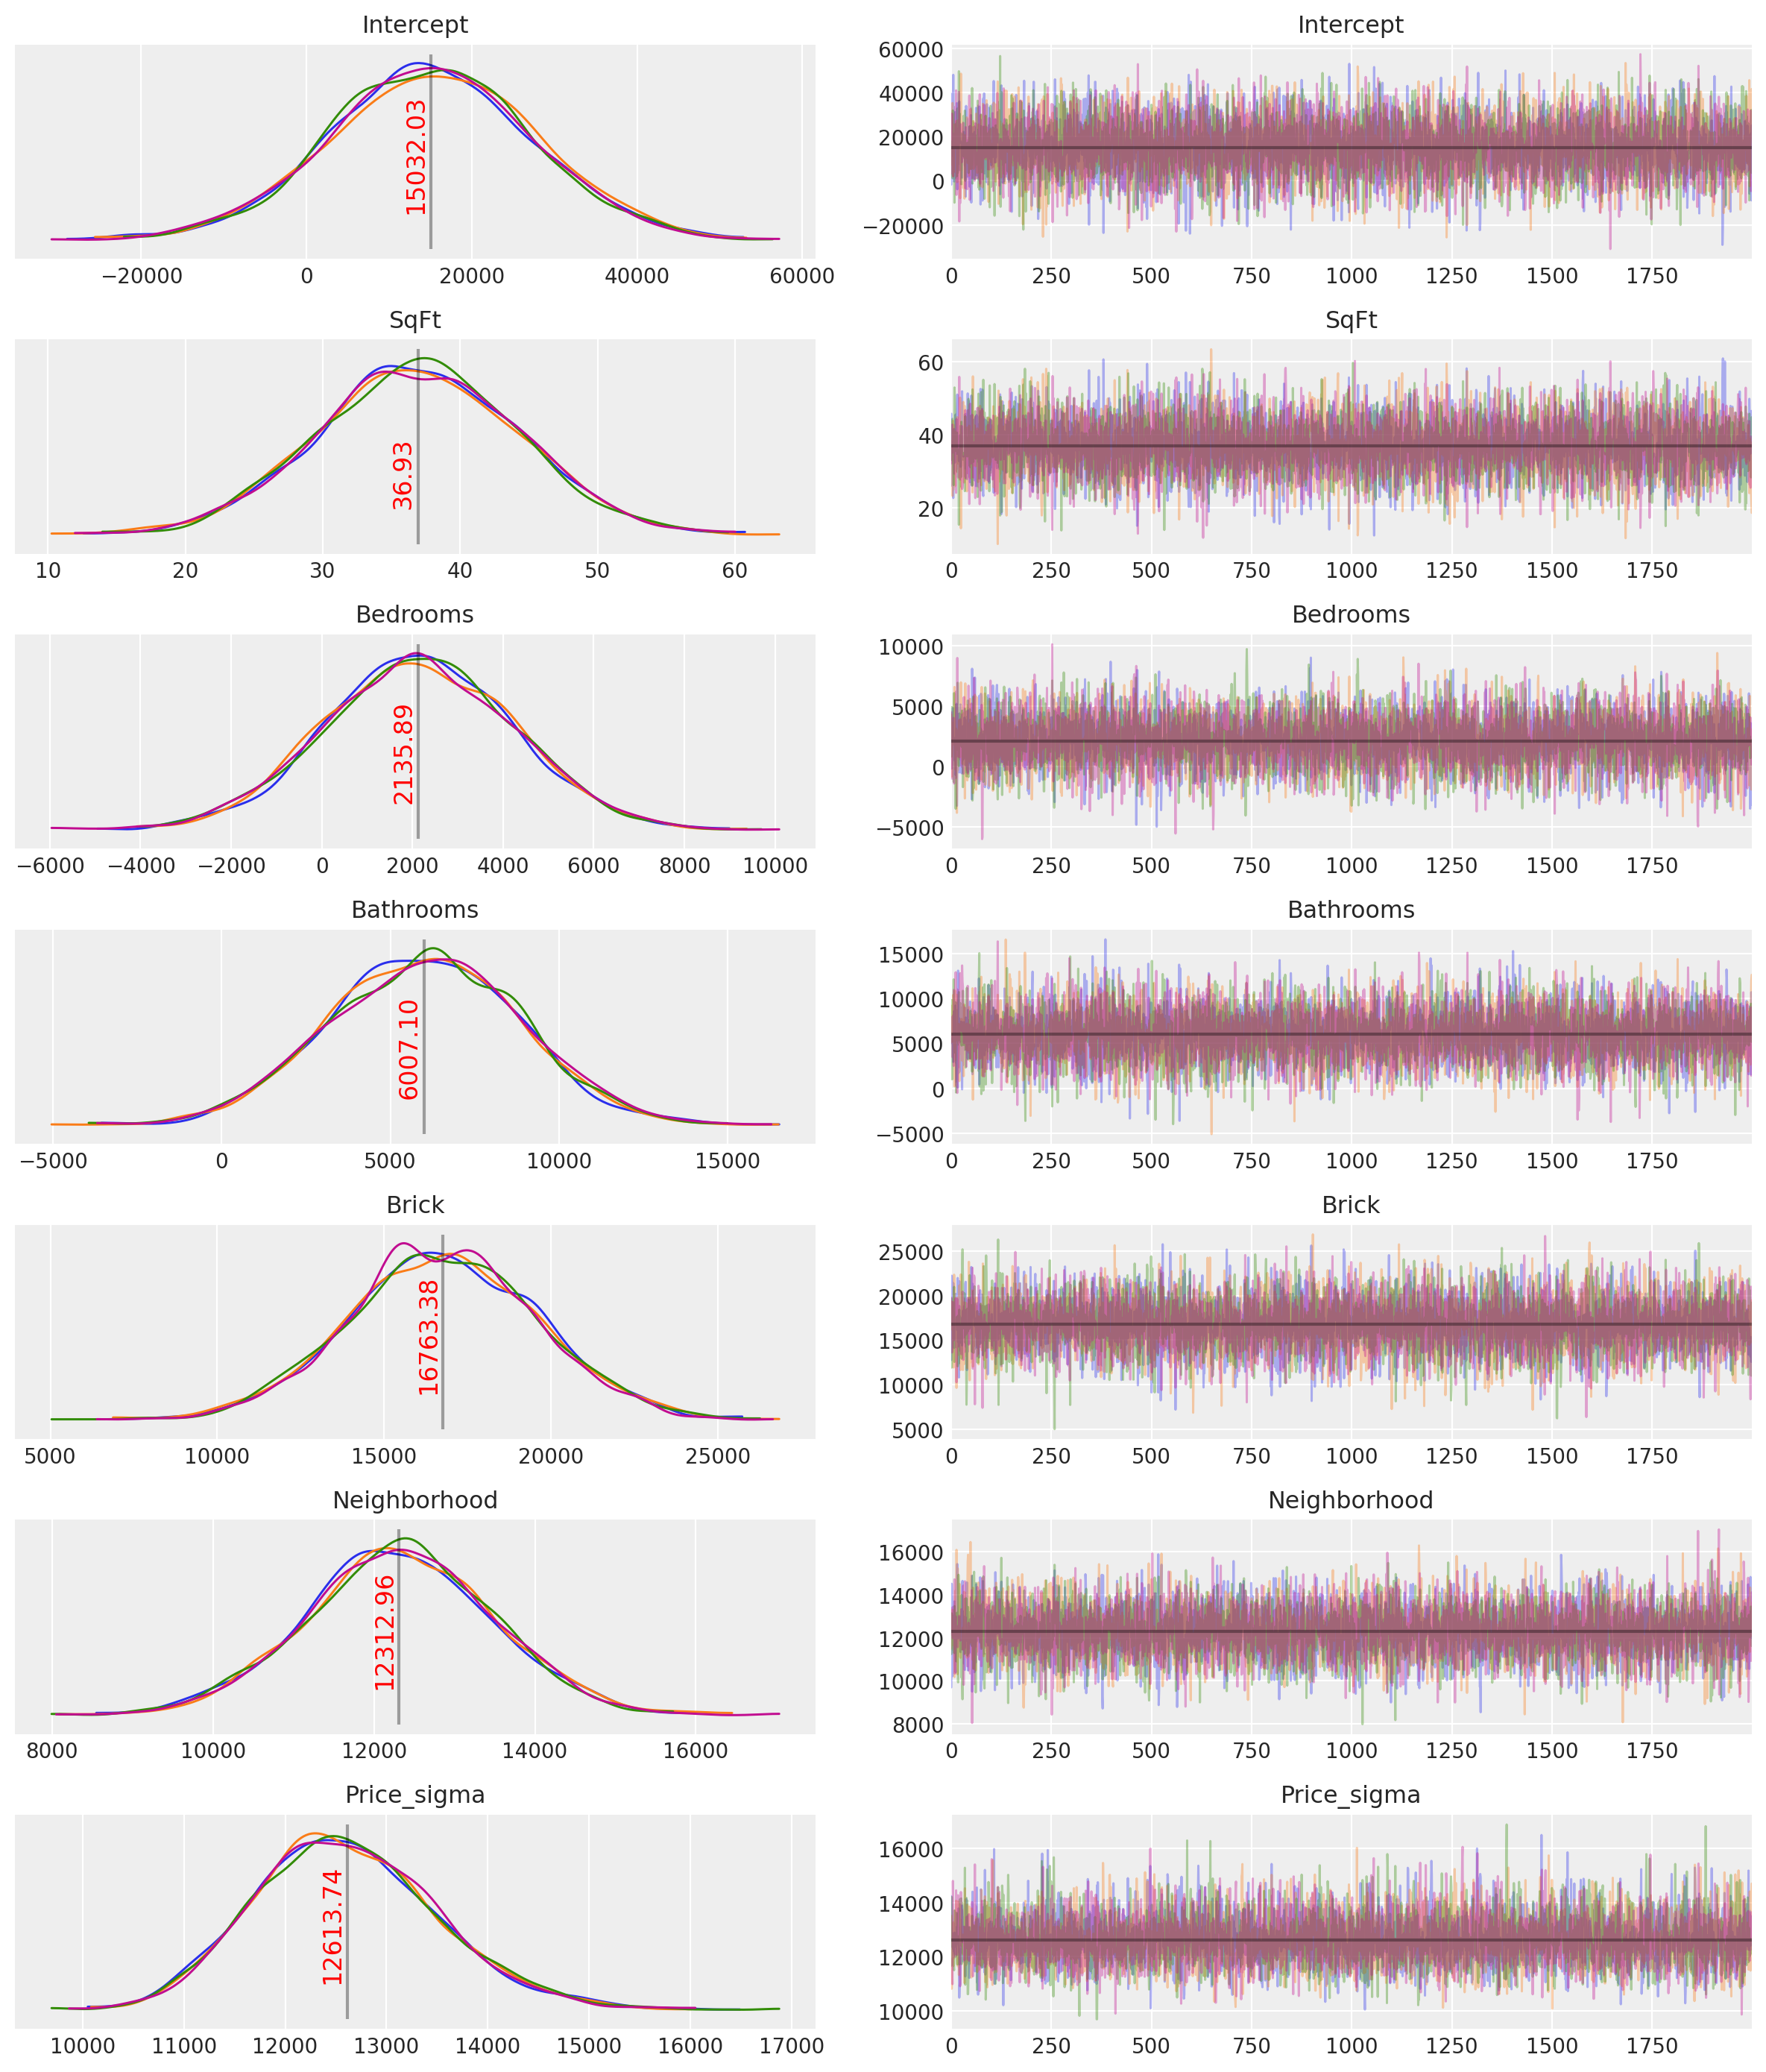

In [8]:
# Lets plot the trace of the chains and draws. If we see some oddities in the beginning of the trace plot it could signify we need to throw out
# the burn-in phase. Trends afer the beginning draws could signify we have a poorly defined model. Looks good for now though.
var_names = list(pm.summary(fitted).index.values)
# Lets plot the mean of the trace plot for each model parameter.
lines = list(az.sel_utils.xarray_var_iter(fitted.posterior[var_names].mean(dim=("chain", "draw")), skip_dims={"chain"}))
var = []
for line in lines:
    var.append((line[0], line[1], line[3]))
ax = az.plot_trace(fitted, lines=var, compact=False)
for i, mn in enumerate(pm.summary(fitted)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 12,
                          xytext = (-13, 13), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', color = 'red')
plt.pyplot.tight_layout()

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'SqFt'}>,
        <AxesSubplot:title={'center':'Bedrooms'}>],
       [<AxesSubplot:title={'center':'Bathrooms'}>,
        <AxesSubplot:title={'center':'Brick'}>,
        <AxesSubplot:title={'center':'Neighborhood'}>],
       [<AxesSubplot:title={'center':'Price_sigma'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

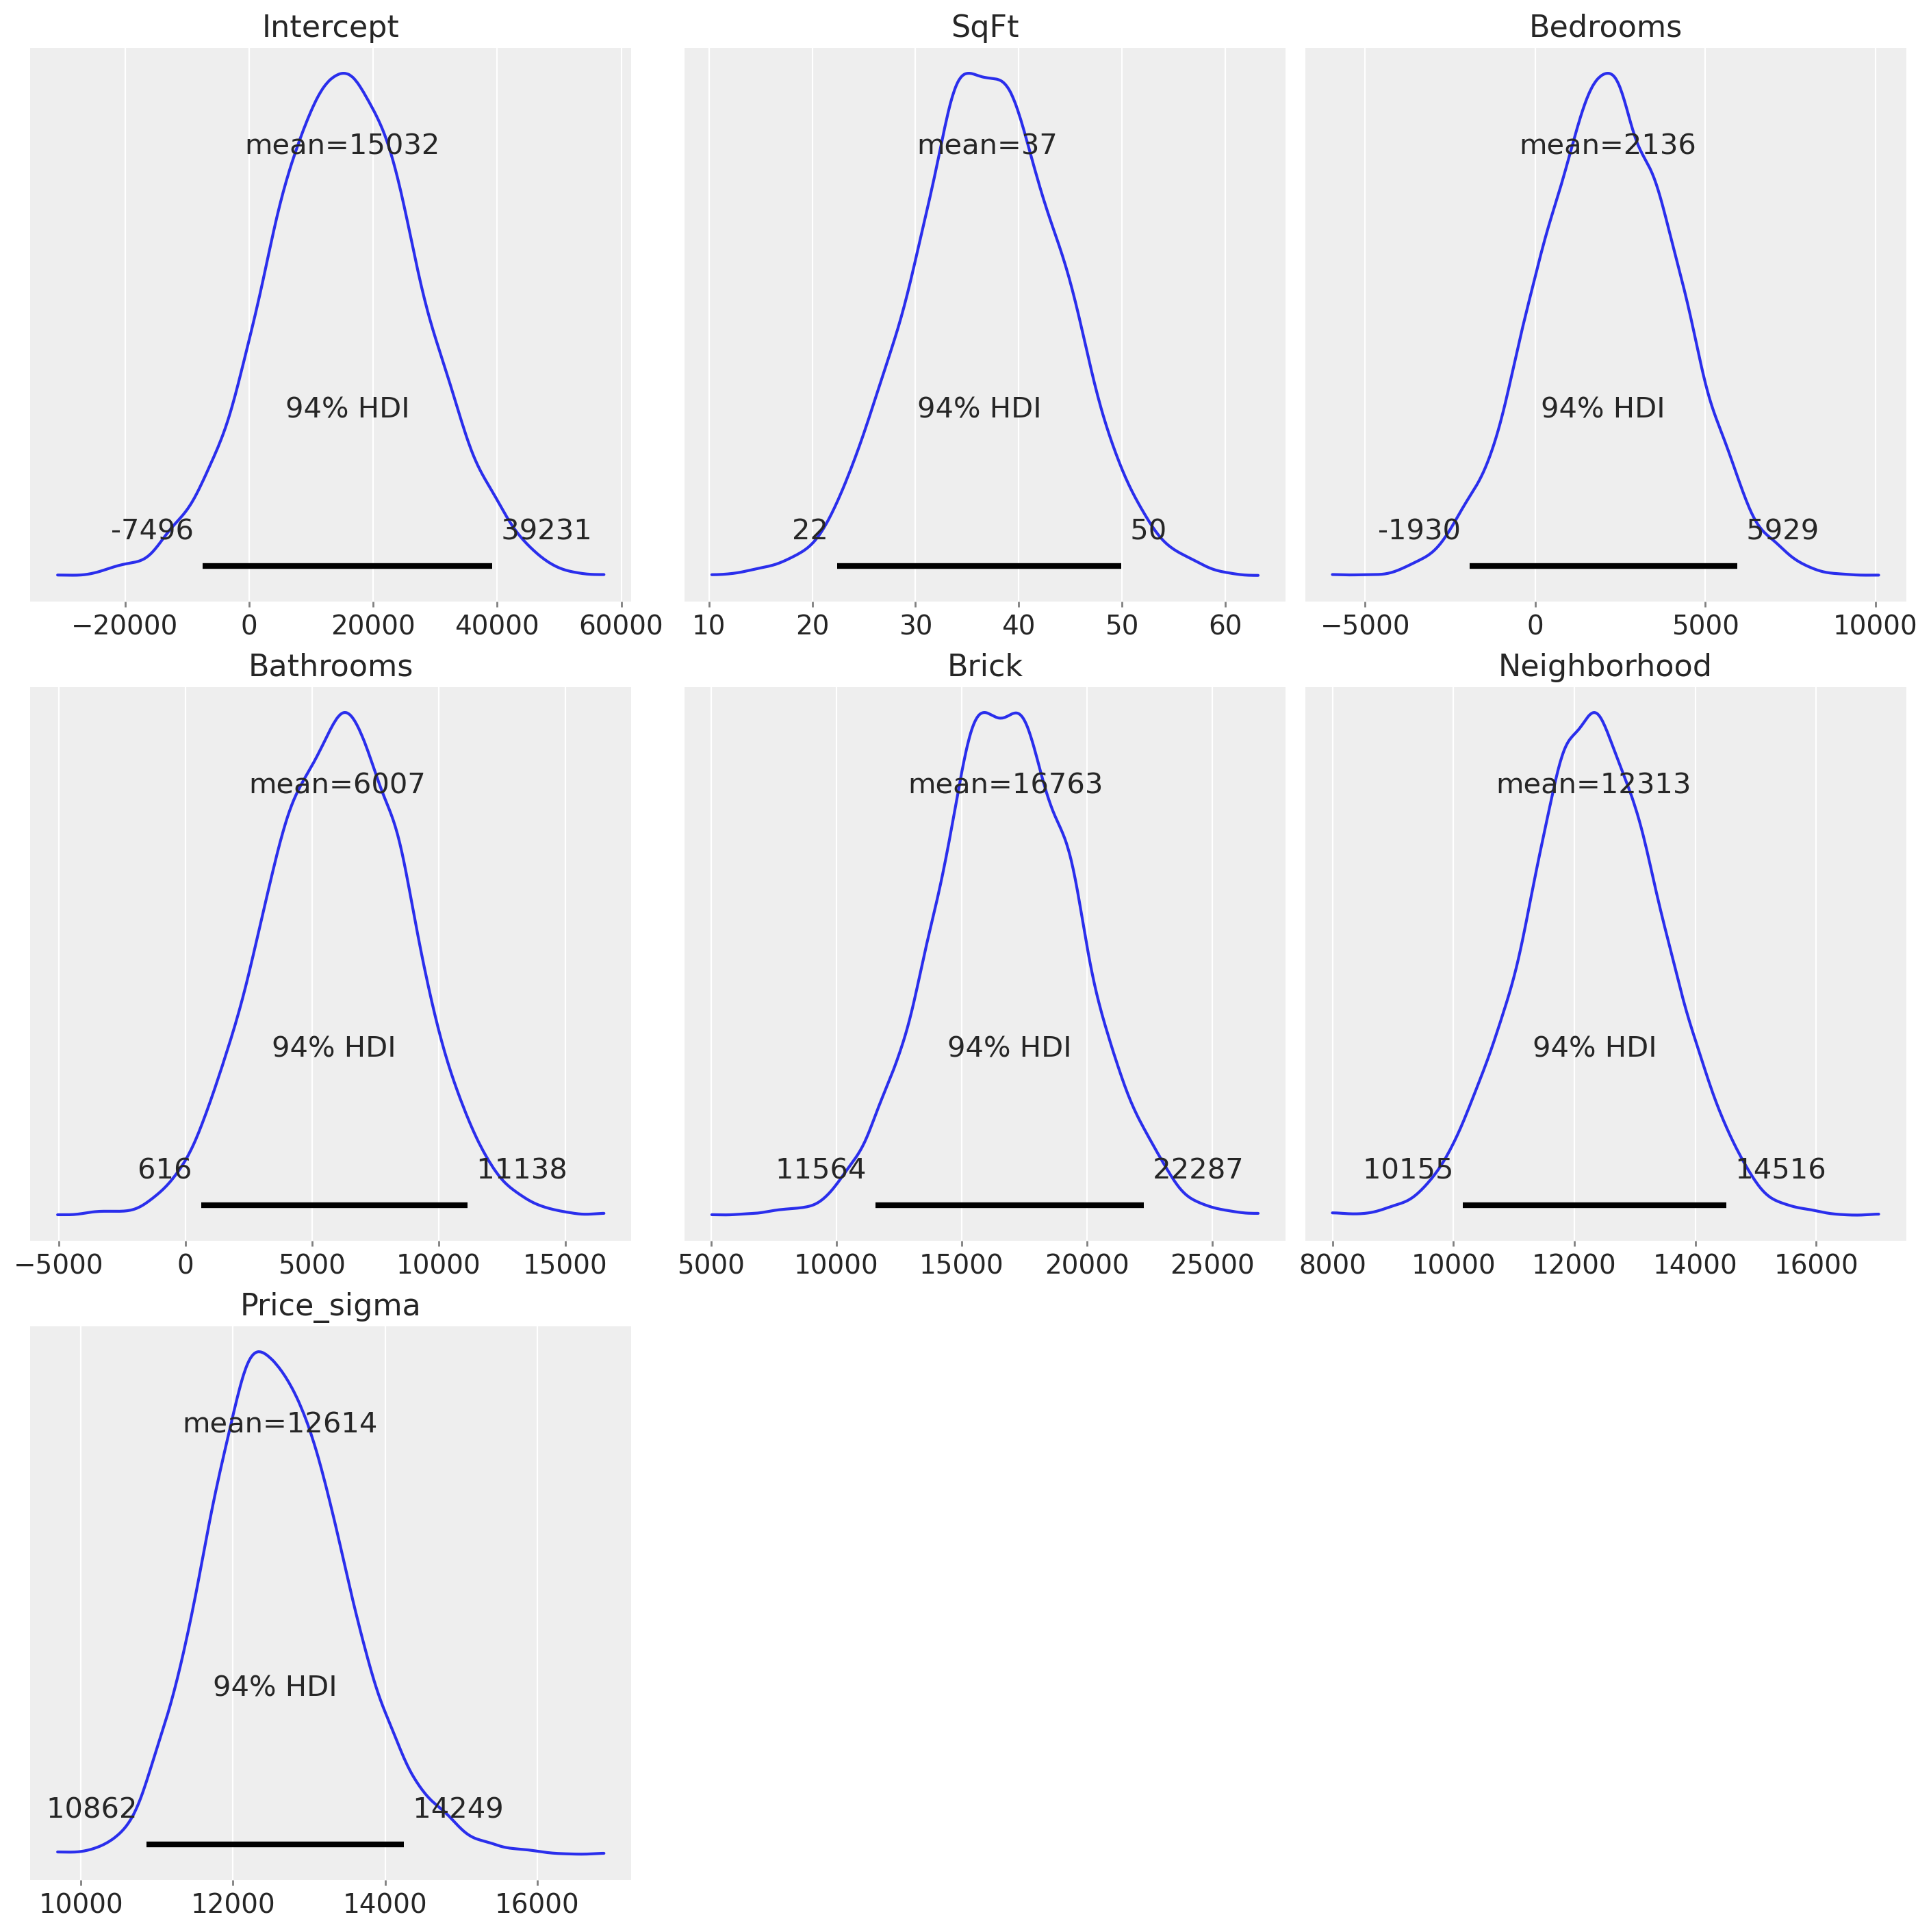

In [9]:
# To neatly lay out the the credibility interval for the above trace plot we can show the Highest Density Interval (HDI)
pm.plot_posterior(fitted, figsize = (14, 14))

In [13]:
# And this is just the posterior info tabulated.  
pm.summary(fitted.posterior)

mean         sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
Intercept     14875.142  12707.517  -9409.350  38162.731    126.538   99.007   
SqFt             37.065      7.562     23.333     51.542      0.082    0.058   
Bedrooms       2113.286   2112.700  -1775.634   6127.001     22.774   18.585   
Bathrooms      5971.312   2904.457    745.829  11587.403     31.437   24.524   
Brick         16736.463   2890.273  11226.638  22030.176     31.530   22.491   
Neighborhood  12349.241   1215.225   9987.484  14568.968     12.800    9.115   
Price_sigma   12625.629    931.660  10873.393  14340.983     10.482    7.454   

              ess_bulk  ess_tail  r_hat  
Intercept      10062.0    7289.0    1.0  
SqFt            8587.0    6223.0    1.0  
Bedrooms        8622.0    6696.0    1.0  
Bathrooms       8446.0    5826.0    1.0  
Brick           8411.0    6448.0    1.0  
Neighborhood    9021.0    5539.0    1.0  
Price_sigma     7950.0    5908.0    1.0

So now that we have sampled from the posterior we have estimates for our model parameters, along with distributions highlighting our uncertainty in these estimates. In practice its important to check for convergence (r_hat ~ 1.0) and auto-correlation at this point to ensure your model is properly behaving.

We can now compare the estimated parameters to the benchmark OLS done previously. We can actually see the R^2 value is slightly worse for the Bayesian model, but the feature coefficients are pretty similar. 

In [153]:
# Printing OLS and Bayesian Formulas and comparing scores:
Bayes_formula = 'Price = %0.2f ' % pm.summary(fitted)['mean']['Intercept']
for variable in var_names[1:]:
    Bayes_formula += '+ %0.2f * %s ' % (pm.summary(fitted)['mean'][variable], variable)

' '.join(Bayes_formula.split(' ')[:-1])

y_true = fitted.observed_data["Price"].values
y_pred = fitted.posterior_predictive.stack(sample=("chain", "draw"))["Price"].values.T
print(f'OLS Formula:\n {ols_formula}\nOLS R^2:\n {OLS_score}\n')
print(f'Bayesian Formula:\n {Bayes_formula}\nBayesian R^2:\n{az.r2_score(y_true, y_pred)}\n')



OLS Formula:
 Price = 14816.94 + 37.06 * SqFt + 2139.08 * Bedrooms + 5987.76 * Bathrooms + 16717.60 * Brick + 12321.41 * Neighborhood 
OLS R^2:
 0.804202691328443

Bayesian Formula:
 Price = 15041.05 + 36.96 * SqFt + 2141.99 * Bedrooms + 5970.07 * Bathrooms + 16750.30 * Brick + 12313.49 * Neighborhood + 12598.94 * Price_sigma 
Bayesian R^2:
r2        0.780513
r2_std    0.005533
dtype: float64



To highlight what happened with the model above we can show some of the lines sampled from the posterior. 

Visualizing the lines is easiest in 2D, so lets plot the home SqFt against Price. 
Taking just some of the features (intercept, Sqft, Brick, and Neighborhood) we plot 200 odd sampled lines in black. 
You can see the darker regions of the plot are where more trend lines were sampled from, corresponding to those model parameter values having a higher probability of occuring. The average line out of all these lines is orange. Note the trend lines won't fit the scatter plot perfectly since its only partial inputs, and SqFt doesn't explain everything in the model...

Text(0, 0.5, 'Home Price ($)')

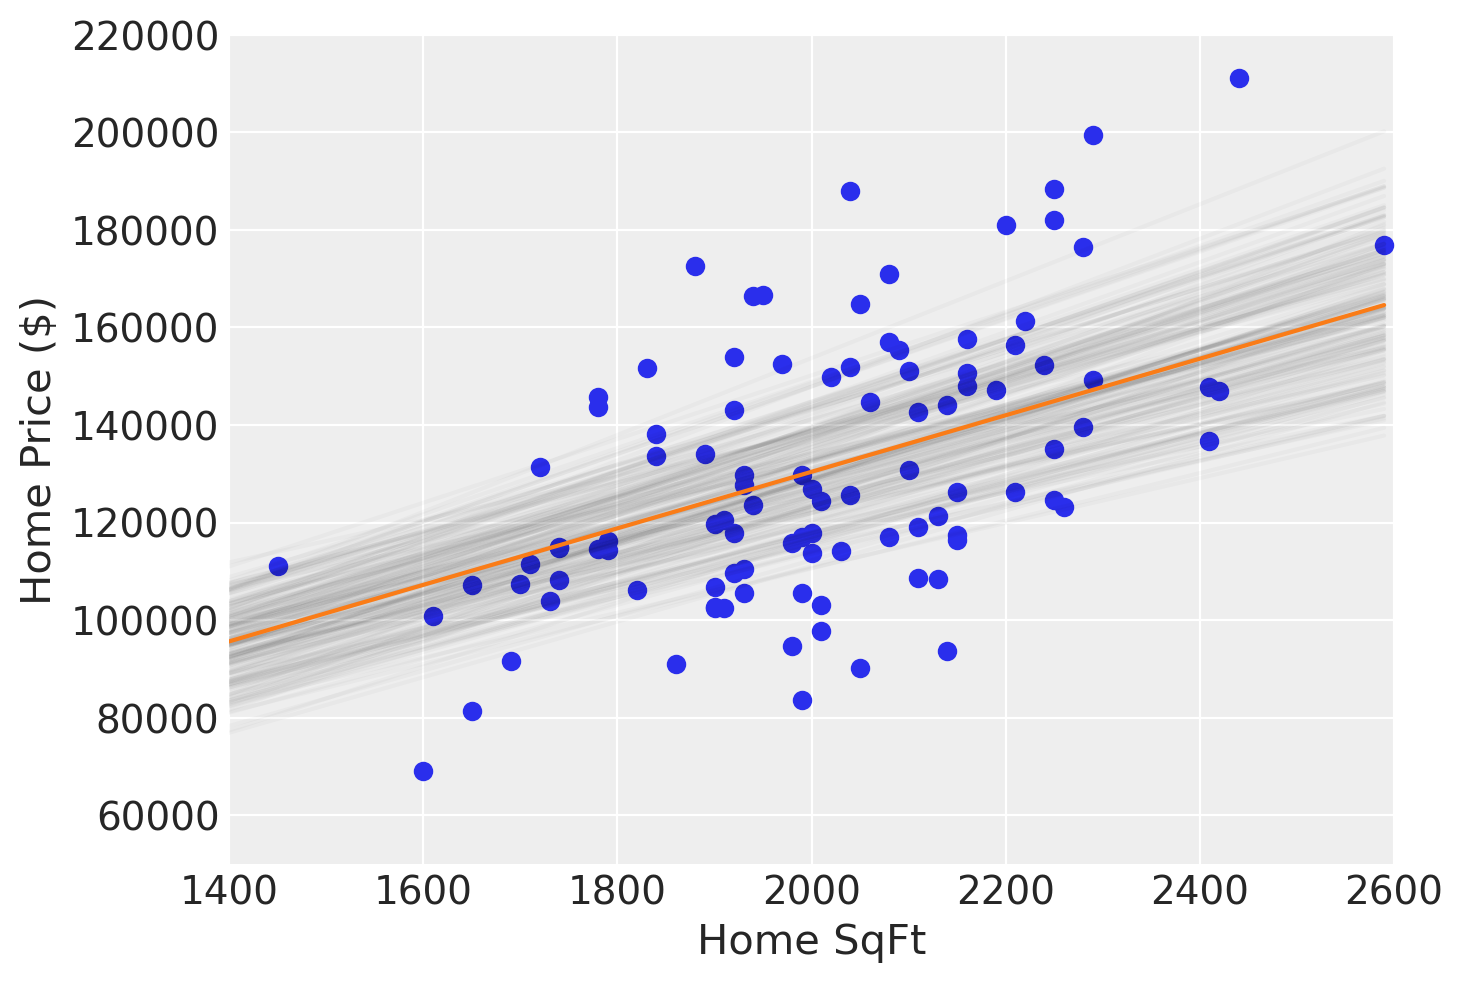

In [158]:
# Plotting posterior for Sqft
x_axis1 = xr.DataArray(np.linspace(0, X_train['SqFt'].max(), num=100), dims=["x_plot"])
x_axis2 = xr.DataArray(np.linspace(0, X_train['Brick'].max(), num=100), dims=["x_plot"])
x_axis3 = xr.DataArray(np.linspace(0, X_train['Neighborhood'].max(), num=100), dims=["x_plot"])

mu_pred = fitted.posterior["Intercept"] + fitted.posterior["SqFt"] * x_axis1 + fitted.posterior["Brick"] * x_axis2 + fitted.posterior["Neighborhood"] * x_axis3
mu_plot = mu_pred.stack(sample=("chain", "draw"))
mu_mean = mu_pred.mean(dim=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:200]

plt.pyplot.scatter(X_train['SqFt'], y_train)
plt.pyplot.plot(x_axis1, mu_plot.isel(sample=random_subset), color="black", alpha=0.025)
plt.pyplot.plot(x_axis1, mu_mean, color="C1");
plt.pyplot.xlim([1400, 2600])
plt.pyplot.ylim([50000, 220000])
plt.pyplot.xlabel('Home SqFt')
plt.pyplot.ylabel('Home Price ($)')

As we described earlier a good method for validating the Bayesian model is a PPC. Essentially all we are doing is taking the model parameters generated, and seeing if they would produce a similar sythetic data set if sampled a bunch of times. We can see from the plot below that the mean of the posterior predictive distribution roughly follows the observed data. We could improve this with some more informative priors.

<AxesSubplot:xlabel='Price / Price'>

C:\Users\Ralph\anaconda3\envs\pm3env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


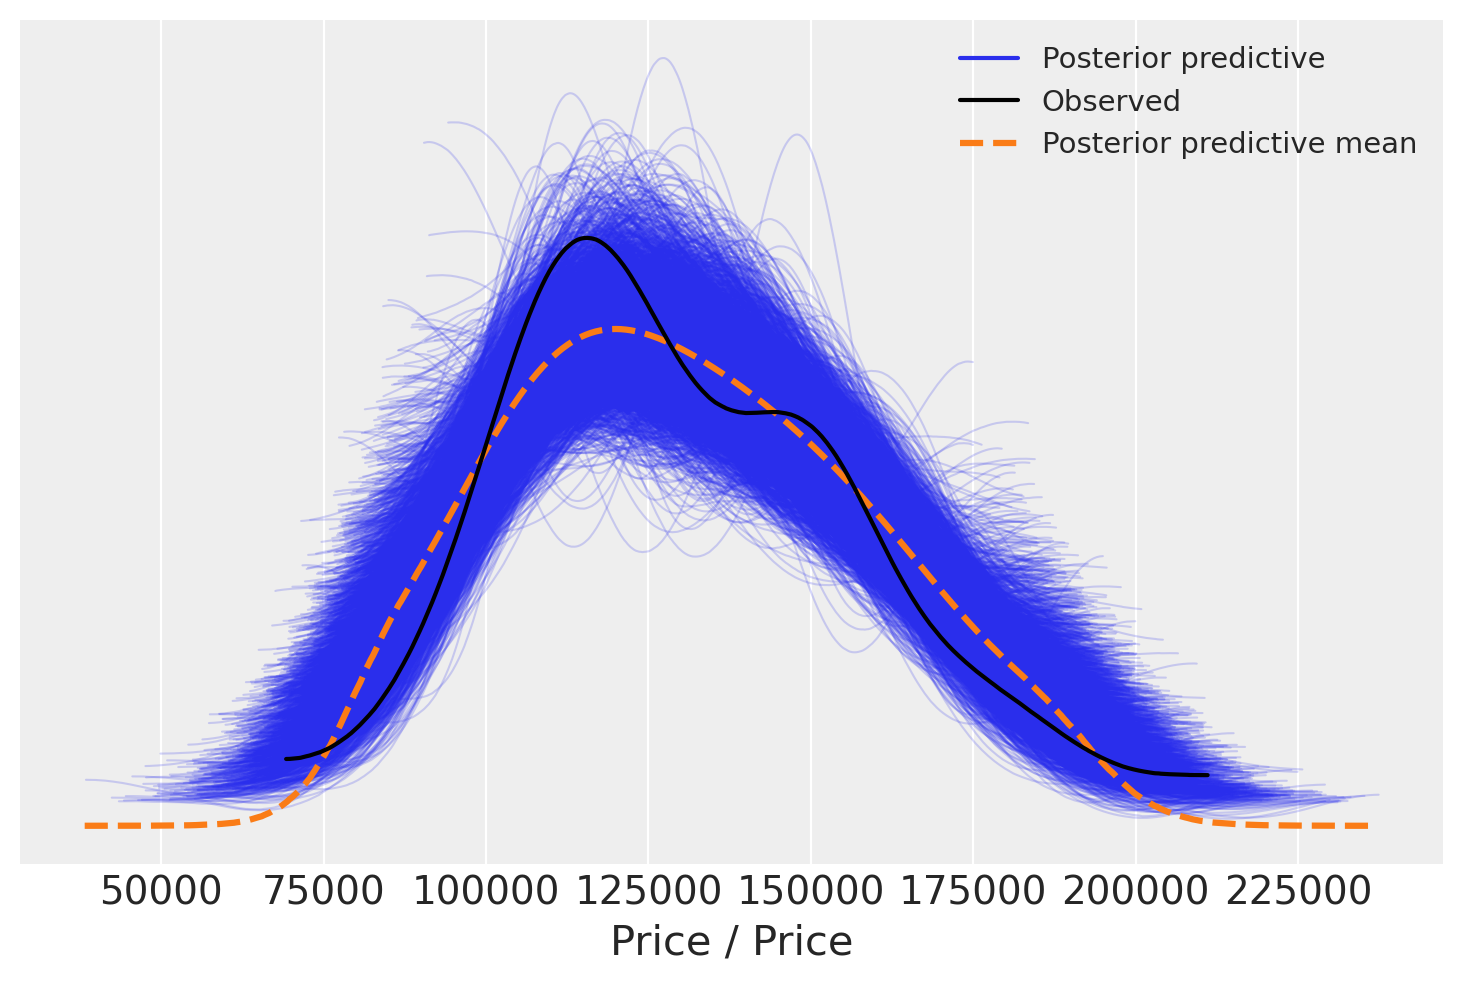

In [14]:
#Posterior Predictive Check: Checking the distribution of simulated price data and comparing it to the observed data.
az.plot_ppc(fitted)

# Predictions
Okay now that we've gone through all the extra trouble of creating the seemingly less accurate Bayesian linear regression, quantifying out of sample (test set) prediction uncertainty is where it shines. 

It may be tempting to assume all the uncertainty in price predictions will be encapsulated by the "Price_sigma" term we found from the posterior. Then take that Sd value, slap a normal around a mean prediction, and call it a day. Not so fast...

Doing this would miss some of the uncertainty around the other model parameters, and the sampling error itself. To get the actual uncertainty around an out of sample prediction we need to sample the posterior at those given input features using the predict method (done above) from bambi again.

In [159]:
# Posterior predictions on the test set to check accuracy. 

# This function just takes a test set index, shows the posterior predictive distribution around the given feature values. 
# The actual observed value is also shown so we can see how close we were. 
def test_dist(test_ind):
    # Stack the xarray for the observation
    hdi = az.stats.stats.hdi(fitted.posterior_predictive[dict(Price_dim_0=test_ind)])
    test_val = fitted.posterior_predictive[dict(Price_dim_0=test_ind)].stack(sample=("chain", "draw"))
    test_val = test_val.to_dataframe() # Converting to dataframe for my own sanity
    hdi = hdi.to_dataframe()
    
    print(f"Test Observation:\n{X_test_comb.iloc[test_ind]}\n\nPrediction: {test_val['Price'].mean()}\n")
    print(f"Lower 94% C.I.: {hdi['Price']['lower']}\nUpper 94% C.I.: {hdi['Price']['higher']}")    
    
    #plots
    sns.distplot(test_val['Price'], kde=True, label='est. Price Distribution')
    plt.pyplot.axvline(X_test_comb.iloc[test_ind]['Price'], c='red', label='Observed Price', linestyle='--', linewidth=2)
    plt.pyplot.axvline(test_val['Price'].mean(), c='black', label='Mean Price Prediction', linewidth=2)
    plt.pyplot.axvline(hdi['Price']['lower'], c='orange', label='low/high 94% C.I.', linewidth=2, ymax=0.3)
    plt.pyplot.axvline(hdi['Price']['higher'], c='orange', linewidth=2, ymax=0.3)
    plt.pyplot.legend()

Test Observation:
Price           125700
SqFt              1720
Bedrooms             2
Bathrooms            2
Brick                1
Neighborhood         1
Name: 55, dtype: int64

Prediction: 124064.83955167365

Lower 94% C.I.: 100046.6554139817
Upper 94% C.I.: 149540.48549541616


C:\Users\Ralph\anaconda3\envs\pm3env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


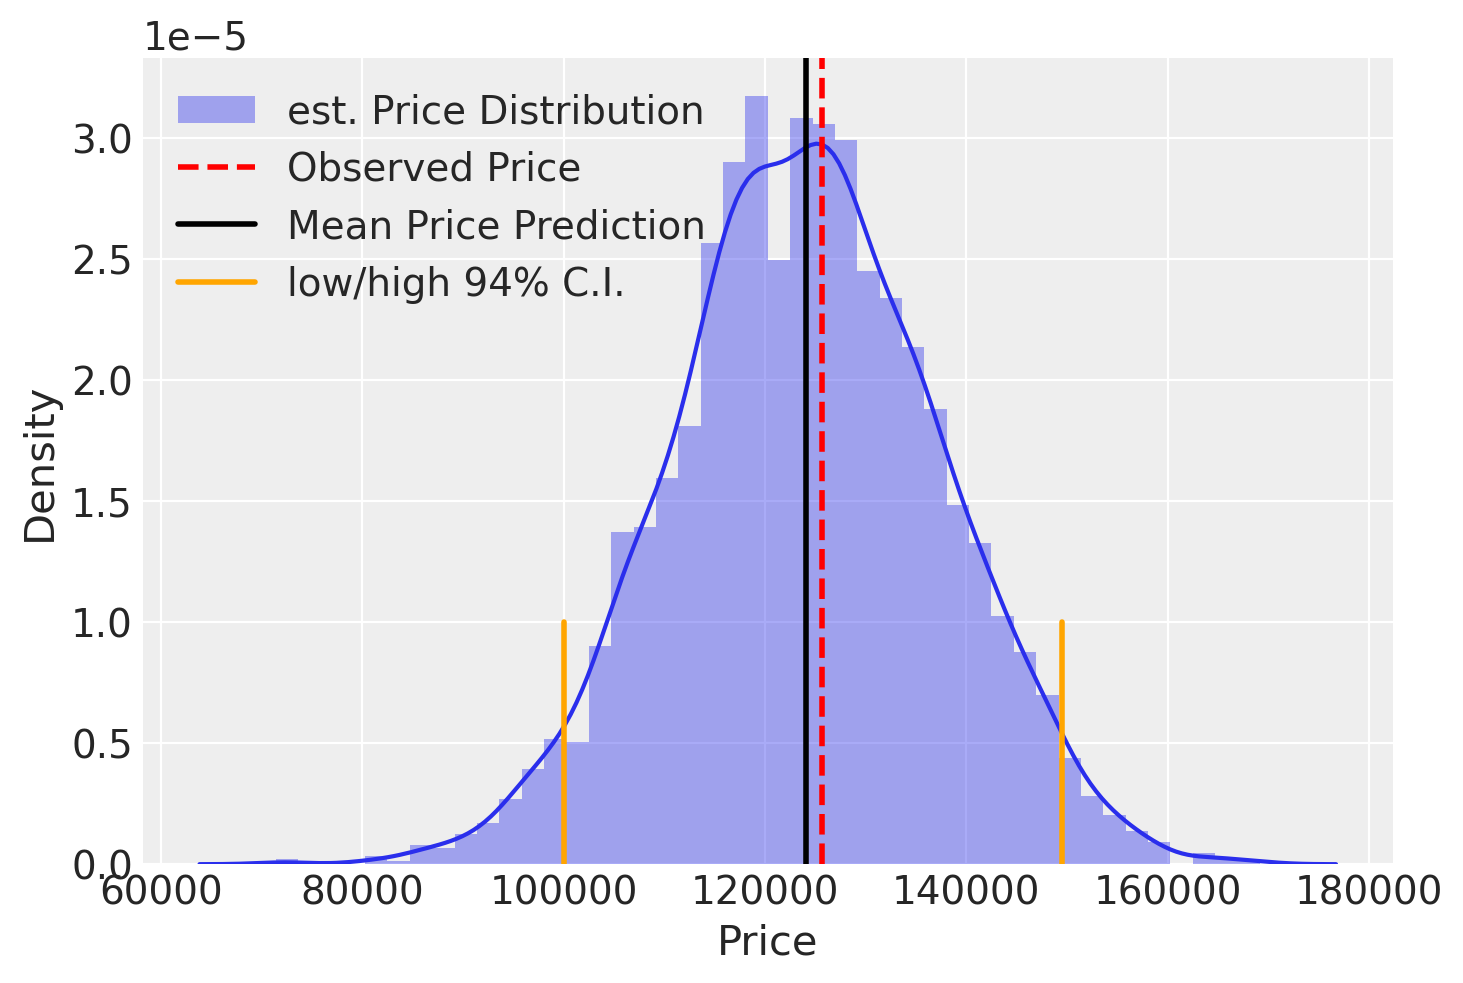

In [161]:
# Lets take a peak at the test set first value
test_dist(0)

You can see in this case our average estimate was pretty close to the observed price. Most importantly though, we were able to determine a range in which the price had a high probability of occuring.